## CALIBRATION

Imports

In [1]:
import cv2
from matplotlib import pyplot as plt
from copy import deepcopy
from pprint import pprint as pp
import os
import numpy as np


Load images

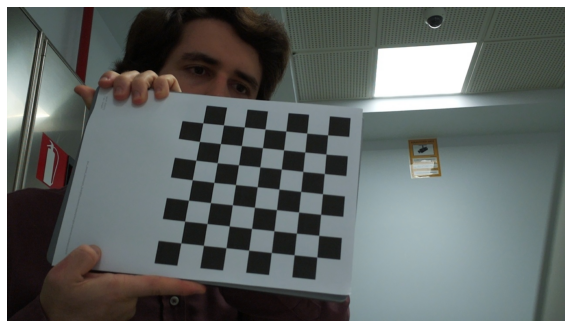

In [2]:
folder = 'images/'
img_names = [f'image{i}.jpg' for i in range(1, 29)]
imgs = [cv2.imread(folder + img_name) for img_name in img_names]
# Show the first image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(imgs[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

Detecciones correctas vs incorrectas

In [3]:
corners = []
images = []

for img in (imgs):
    ret, c = cv2.findChessboardCorners(img, (7,7))
    if ret == True:
        corners.append([ret, c])
        images.append(img)

print(f"Nº de imágenes con detecciones correctas: {len(corners)}")
print(f"Nº de imágenes sobre las que estamos intentando dibujar puntos: {len(images)}")

# pp(corners)

Nº de imágenes con detecciones correctas: 28
Nº de imágenes sobre las que estamos intentando dibujar puntos: 28


Refine the corners

In [4]:
# OPTIONAL => cornerSubPix is a destructive function. so we need to copy corners to avoid data loss
corners_2 = deepcopy(corners) 

# termination criteria (https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

#utilizaremos la función de openCV "cornerSubPix" para refinar el valor de las esquinas calculadas. OJO que esta función necesita 
#que las imágenes del patrón de calibración estén en escala de grises primero
# PASA Cada una de las imagenes la volvemos a blanco y negro
imgs_grey = [cv2.cvtColor (original_image, cv2.COLOR_BGR2GRAY) for original_image in images]

# For each image and corners we are going to use cornerSubPix
cornersRefined = [cv2.cornerSubPix(i, cor[1], (7, 7), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_grey, corners_2)]

# pp(cornersRefined)

Draw Chessboard Corners

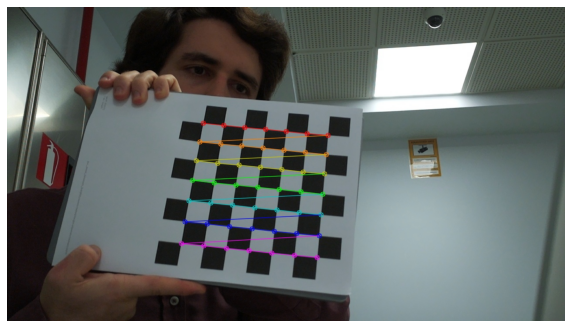

In [12]:
images_2 = deepcopy(images)
folder = 'images_chessboard/'

for i, (img, cor) in enumerate(zip(images_2, cornersRefined)):
    cv2.drawChessboardCorners(image=img, patternSize=(7,7), corners=cor, patternWasFound=True)
    # cv2.imshow(f'Chessboard with corners {i+1}', img)
    cv2.imwrite(f'{folder}image{i}.jpg', img)
    # plt.imsave(f'{folder}image{i}.jpg', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

# We show the first image
img = cv2.imread(folder + 'image0.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [6]:
def get_chessboard_points(chessboard_shape, dx, dy):
    """
    params:
        chessboard_shape: tuple of (rows, cols) of the chessboard
        dx: distance between corners in x direction in WCS
        dy: distance between corners in y direction in WCS
    returns:
        coordinates_array: array of shape (rows * cols, 3) with the coordinates of the chessboard corners
    """
    
    coordinates_array = np.zeros((chessboard_shape[0]*chessboard_shape[1], 3))
    for j in range(chessboard_shape[0]):
        for i in range(chessboard_shape[1]):
                coordinates_array[j*chessboard_shape[1]+i][0] = i*dx
                coordinates_array[j*chessboard_shape[1]+i][1] = j*dy
    return coordinates_array
    
#HINT: how to call the funtion:
cb_points = get_chessboard_points((7, 7), 23, 23)
cb_points

array([[  0.,   0.,   0.],
       [ 23.,   0.,   0.],
       [ 46.,   0.,   0.],
       [ 69.,   0.,   0.],
       [ 92.,   0.,   0.],
       [115.,   0.,   0.],
       [138.,   0.,   0.],
       [  0.,  23.,   0.],
       [ 23.,  23.,   0.],
       [ 46.,  23.,   0.],
       [ 69.,  23.,   0.],
       [ 92.,  23.,   0.],
       [115.,  23.,   0.],
       [138.,  23.,   0.],
       [  0.,  46.,   0.],
       [ 23.,  46.,   0.],
       [ 46.,  46.,   0.],
       [ 69.,  46.,   0.],
       [ 92.,  46.,   0.],
       [115.,  46.,   0.],
       [138.,  46.,   0.],
       [  0.,  69.,   0.],
       [ 23.,  69.,   0.],
       [ 46.,  69.,   0.],
       [ 69.,  69.,   0.],
       [ 92.,  69.,   0.],
       [115.,  69.,   0.],
       [138.,  69.,   0.],
       [  0.,  92.,   0.],
       [ 23.,  92.,   0.],
       [ 46.,  92.,   0.],
       [ 69.,  92.,   0.],
       [ 92.,  92.,   0.],
       [115.,  92.,   0.],
       [138.,  92.,   0.],
       [  0., 115.,   0.],
       [ 23., 115.,   0.],
 

Extrinsics

In [11]:
# We are going to retrieve existing corners (cor[0] == True)
valid_corners = [cor[1] for cor in corners if cor[0]]

num_valid_images = len(valid_corners)

# Matrix with the coordinates of the corners
real_points = get_chessboard_points((7, 7), 23, 23)

# We are going to convert our coordinates list in the reference system to numpy array
object_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

# Convert the corners list to array
image_points = np.asarray(valid_corners, dtype=np.float32)

# ASIGNMENT: Calibrate the left camera
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imgs_grey[0].shape[::-1], None, None)
# Calculate extrinsecs matrix using Rodigues on each rotation vector addid its translation vector
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))
# Save the calibration file
np.savez('calib_left', intrinsic=intrinsics, extrinsic=extrinsics)

# Lets print some outputs
print("Corners standard intrinsics:\n",intrinsics)
print("Corners standard dist_coefs:\n", dist_coeffs)
print("root mean square reprojection error:\n", rms)

Corners standard intrinsics:
 [[1.35673110e+03 0.00000000e+00 6.45273037e+02]
 [0.00000000e+00 1.34598207e+03 3.27961483e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Corners standard dist_coefs:
 [[ 0.11559444 -0.97390566 -0.01859563  0.00650255  2.67124903]]
root mean square reprojection error:
 0.454994747435242
